In [1]:
import numpy as np
import pandas as pd
import sqlite3 as sq
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import networkx as nx
import geopandas as gpd
import folium
from sklearn.cluster import KMeans
from math import ceil
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM
import optuna
import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split, RepeatedStratifiedKFold#For splitting
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, recall_score, precision_score,classification_report,confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
#pd.set_option('display.max_columns', None)
import scipy.stats as stats

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool 

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRegressor, DMatrix
from sklearn.metrics import log_loss
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Loading the cleaned datasets

accident=pd.read_csv('accident.csv')
vehicle=pd.read_csv('vehicle.csv')
casualty=pd.read_csv('casualty.csv')
lsoa=pd.read_csv('lsoa.csv')


#Loading the merged Dataset
df=pd.read_csv('df.csv')

In [3]:
accident.nunique()

accident_index                                 91199
accident_year                                      1
accident_reference                             91199
location_easting_osgr                          75404
location_northing_osgr                         75499
longitude                                      89590
latitude                                       88749
police_force                                      44
accident_severity                                  3
number_of_vehicles                                13
number_of_casualties                              16
date                                             366
day_of_week                                        7
time                                            1438
local_authority_district                         377
local_authority_ons_district                     378
local_authority_highway                          206
first_road_class                                   6
first_road_number                             

In [4]:
accident.date

0        2020-02-04
1        2020-04-27
2        2020-01-01
3        2020-01-01
4        2020-01-01
            ...    
91194    2020-08-12
91195    2020-11-13
91196    2020-04-15
91197    2020-12-15
91198    2020-08-25
Name: date, Length: 91199, dtype: object

In [5]:
accident['datetime']=pd.to_datetime(accident['datetime'])
accident['day_of_month']=accident['datetime'].dt.day
accident['day_of_year']=accident['datetime'].dt.dayofyear
accident['month']=accident['datetime'].dt.month
accident['time']  =accident['datetime'].dt.hour


df['datetime']=pd.to_datetime(df['datetime'])
df['day_of_month']=df['datetime'].dt.day
df['day_of_year']=df['datetime'].dt.dayofyear
df['month']=df['datetime'].dt.month
df['time']  =df['datetime'].dt.hour

# List of public holidays
public_holidays = [
    '2020-01-01', '2020-01-02', '2020-03-17', '2020-04-10', '2020-04-13', '2020-05-08', 
    '2020-05-25', '2020-07-13', '2020-08-03', '2020-08-31', '2020-11-05', '2020-11-30', '2020-12-25', '2020-12-28'
]

# Convert to datetime
public_holidays = pd.to_datetime(public_holidays).date

# Add a column to indicate public holidays
df['is_public_holiday'] = df['date'].isin(public_holidays)
accident['is_public_holiday'] = accident['date'].isin(public_holidays)



def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'


df['season'] = df['month'].apply(get_season)
accident['season'] = accident['month'].apply(get_season)


In [6]:
categ_cols = [col for col in accident if accident[col].nunique() <=400]
num_cols = [col for col in accident if accident[col].nunique() >400]
print(f"Category Columns are: {categ_cols}")

print("-----" * 30)
print(f"Numeric Columns are: {num_cols}")

Category Columns are: ['accident_year', 'police_force', 'accident_severity', 'number_of_vehicles', 'number_of_casualties', 'date', 'day_of_week', 'time', 'local_authority_district', 'local_authority_ons_district', 'local_authority_highway', 'first_road_class', 'road_type', 'speed_limit', 'junction_detail', 'junction_control', 'second_road_class', 'pedestrian_crossing_human_control', 'pedestrian_crossing_physical_facilities', 'light_conditions', 'weather_conditions', 'road_surface_conditions', 'special_conditions_at_site', 'carriageway_hazards', 'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident', 'trunk_road_flag', 'day_of_month', 'day_of_year', 'month', 'is_public_holiday', 'season']
------------------------------------------------------------------------------------------------------------------------------------------------------
Numeric Columns are: ['accident_index', 'accident_reference', 'location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude', 

## Apriori Algorithm Analysis

In [7]:
encoder = OneHotEncoder(sparse_output=False)
df_OH= accident[categ_cols].drop('accident_year',axis=1).copy()
#df_OH = df_OH.drop('Person ID', axis=1)
d= list(df_OH.columns)
encoder.fit(df_OH)
b= encoder.categories_
df_OH=encoder.transform(df_OH)#.toarray()

df_OH= pd.DataFrame(df_OH)
df_OH.columns = encoder.get_feature_names_out(d)
df_OH = df_OH.astype(int)
df_OH.sample(10)

,police_force_1,police_force_3,police_force_4,police_force_5,police_force_6,police_force_7,police_force_10,police_force_11,police_force_12,police_force_13,...,month_8,month_9,month_10,month_11,month_12,is_public_holiday_False,season_Autumn,season_Spring,season_Summer,season_Winter
65321,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
6152,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
30809,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
39631,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
89013,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
47738,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
67637,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0
7921,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
66246,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3952,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [8]:

frq_items = apriori(df_OH, min_support = 0.05, max_len=2, low_memory=True,use_colnames = True)

rules = association_rules(frq_items, metric ="lift", min_threshold = 1)
rules=rules[(rules['antecedents'].apply(lambda x: 'severity' in str(x))) |  (rules['consequents'].apply(lambda x: 'severity' in str(x)))]
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False]).reset_index(drop=True)
rules.sample(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
22,(weather_conditions_2),(accident_severity_3),0.127008,0.783484,0.101723,0.800915,1.022248,0.002214,1.087554,0.024930
97,(accident_severity_3),(day_of_week_2),0.783484,0.140045,0.110977,0.141646,1.011426,0.001254,1.001864,0.052176
9,(junction_control_2),(accident_severity_3),0.114113,0.783484,0.095944,0.840780,1.073129,0.006538,1.359853,0.076924
4,(accident_severity_2),(special_conditions_at_site_0),0.201263,0.957346,0.194388,0.965840,1.008873,0.001710,1.248666,0.011011
35,(day_of_week_4),(accident_severity_3),0.148730,0.783484,0.117962,0.793129,1.012310,0.001434,1.046620,0.014284
119,(accident_severity_3),(time_13),0.783484,0.062950,0.050143,0.064000,1.016678,0.000823,1.001122,0.075764
23,(month_2),(accident_severity_3),0.093707,0.783484,0.074968,0.800023,1.021109,0.001550,1.082704,0.022811
99,(accident_severity_3),(weather_conditions_2),0.783484,0.127008,0.101723,0.129834,1.022248,0.002214,1.003247,0.100517
42,(day_of_week_6),(accident_severity_3),0.163258,0.783484,0.128554,0.787427,1.005032,0.000644,1.018547,0.005984
73,(accident_severity_2),(season_Summer),0.201263,0.260452,0.054540,0.270989,1.040454,0.002121,1.014453,0.048679


In [9]:
rules['consequents'] = rules['consequents'].apply(lambda x: list(x)[0])
rules['antecedents']= rules['antecedents'].apply(lambda x: list(x)[0])

In [10]:
# Analyze the metrics of the filtered rules
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]


,antecedents,consequents,support,confidence,lift
0,accident_severity_2,is_public_holiday_False,0.201263,1.000000,1.000000
1,accident_severity_3,is_public_holiday_False,0.783484,1.000000,1.000000
2,accident_severity_2,pedestrian_crossing_human_control_0,0.195737,0.972542,1.027060
3,accident_severity_2,carriageway_hazards_0,0.195068,0.969218,1.005812
4,accident_severity_2,special_conditions_at_site_0,0.194388,0.965840,1.008873
...,...,...,...,...,...
115,accident_severity_3,month_3,0.056634,0.072285,1.006311
116,accident_severity_3,number_of_vehicles_3,0.053827,0.068703,1.003942
117,accident_severity_3,time_14,0.053707,0.068549,1.001050
118,accident_severity_3,road_type_1,0.051393,0.065596,1.072088


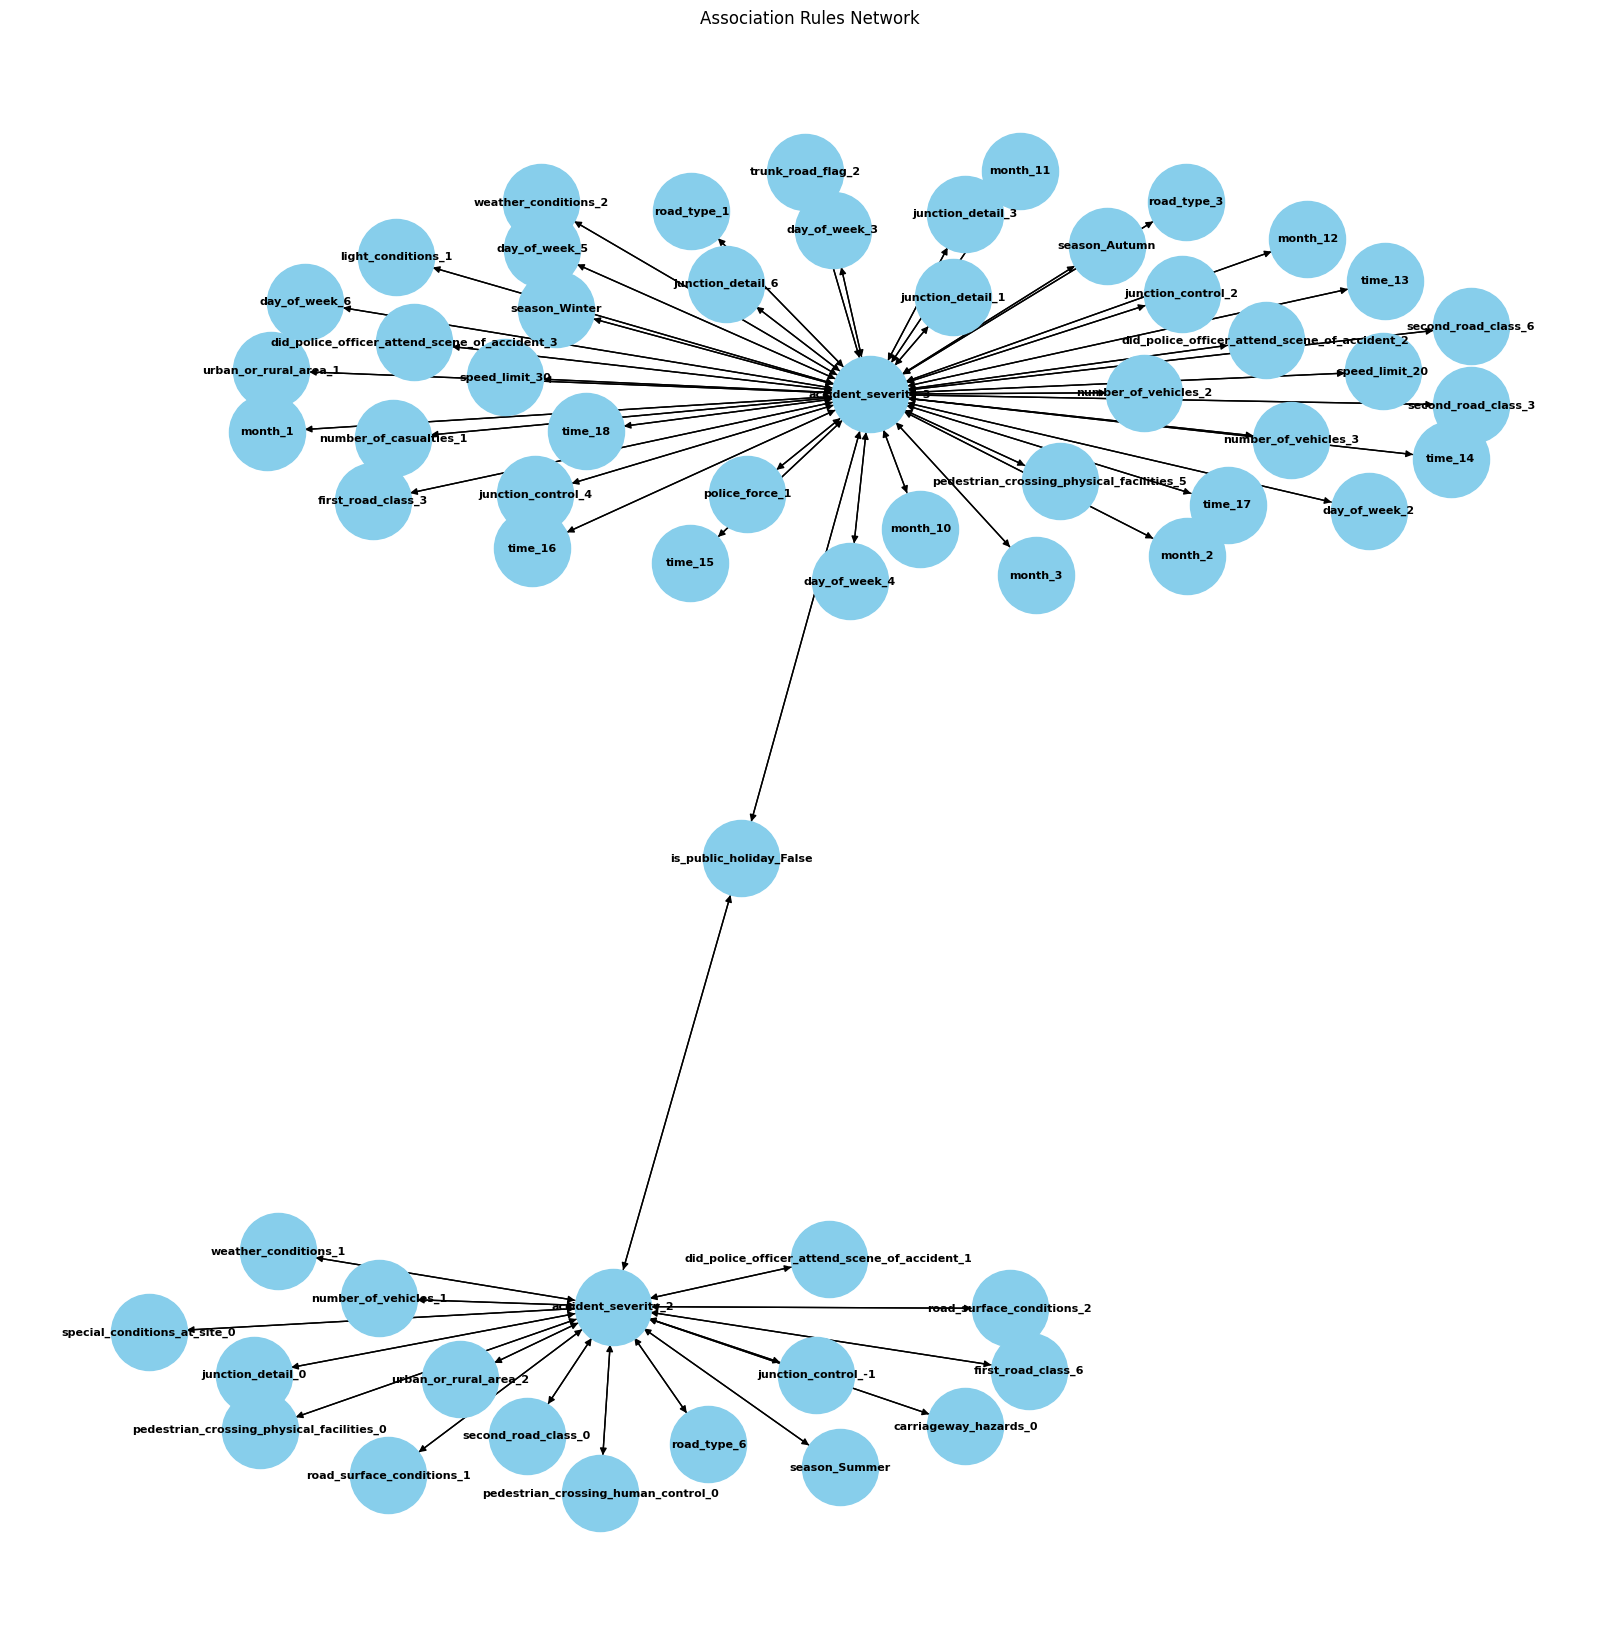

In [11]:
plt.figure(figsize=(16, 16))

# Create a network graph
G = nx.DiGraph()

# Add nodes and edges
for _, row in rules.iterrows():
    G.add_edge(row['antecedents'], row['consequents'], weight=row['lift'])

# Draw the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=8, font_color='black', font_weight='bold')
plt.title('Association Rules Network')
plt.show()


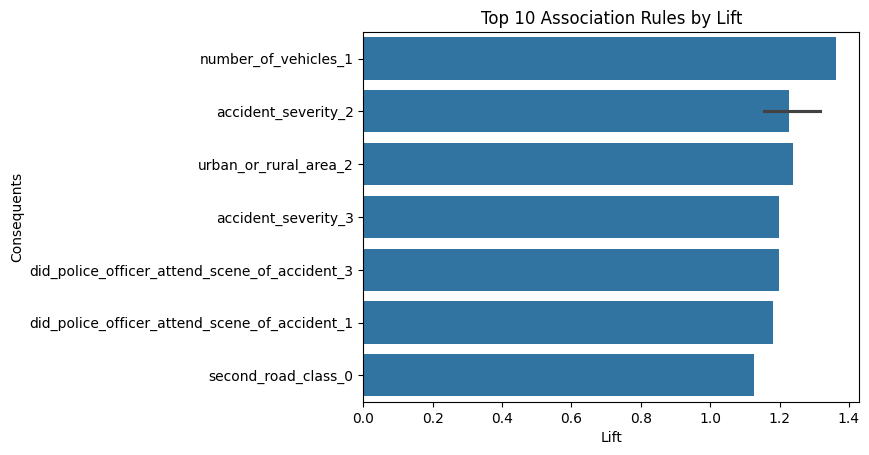

In [12]:

# Plot support, confidence, and lift for the top rules
top_rules = rules.nlargest(10, 'lift')
sns.barplot(x='lift', y='consequents', data=top_rules)
plt.title('Top 10 Association Rules by Lift')
plt.xlabel('Lift')
plt.ylabel('Consequents')
plt.show()


The top rules by lift and confidence seem to be:

<li>accident_severity_2 -> is_public_holiday_False (confidence: 1.0, lift: 1.0)
<li>accident_severity_3 -> is_public_holiday_False (confidence: 1.0, lift: 1.0)
<li>accident_severity_2 -> pedestrian_crossing_human_control_0 (confidence: 0.97, lift: 1.02)

These rules suggest that:

<li>Most accidents, regardless of severity, occur on non-public holidays.
<li>Severity 2 accidents are strongly associated with no human-controlled pedestrian crossings.

## Spatial Analysis and CLustering

In [13]:
locations=['Kingston upon Hull', 'Humberside', 'East Riding of Yorkshire']
lsoa[(lsoa['lsoa01nmw'].apply(lambda x: any(loc in str(x) for loc in locations))) | (lsoa['lsoa01nm'].apply(lambda x: any(loc in str(x) for loc in locations)))]

,objectid,lsoa01cd,lsoa01nm,lsoa01nmw,shape__area,shape__length,globalid
12755,12756,E01012756,Kingston upon Hull 025A,Kingston upon Hull 025A,1.989409e+05,3498.355895,6f44ac4a-9449-4c64-8564-6f612bf9a060
12756,12757,E01012757,Kingston upon Hull 025B,Kingston upon Hull 025B,3.180874e+05,3716.587517,e1c0a075-7ca8-425e-8437-39db56a6b994
12757,12758,E01012758,Kingston upon Hull 018A,Kingston upon Hull 018A,3.119203e+05,3775.303823,a049347f-f7fb-481f-90ca-a95e632ac97a
12758,12759,E01012759,Kingston upon Hull 025C,Kingston upon Hull 025C,3.981882e+05,3984.807880,f55da506-35c7-4db5-a007-bba4255d50e3
12759,12760,E01012760,Kingston upon Hull 025D,Kingston upon Hull 025D,1.259992e+05,2082.915305,dc1e40d1-79fe-4cda-b204-d22f9362b043
...,...,...,...,...,...,...,...
13122,13123,E01013123,East Riding of Yorkshire 015C,East Riding of Yorkshire 015C,3.644844e+06,11262.272080,3ad40331-9db9-4ea4-a6c6-985804322cfb
13123,13124,E01013124,East Riding of Yorkshire 015D,East Riding of Yorkshire 015D,5.571232e+05,8337.438979,fb1f2dc9-faed-41b8-a2d0-70105a20deb9
13124,13125,E01013125,East Riding of Yorkshire 008E,East Riding of Yorkshire 008E,6.880006e+07,54236.778769,5972eaeb-290e-464d-951b-0e79552827e9
13125,13126,E01013126,East Riding of Yorkshire 009E,East Riding of Yorkshire 009E,2.939486e+07,35604.224590,caac0992-6cbd-405f-bf84-eeb846ea54f2


In [14]:
lsoa[(lsoa['lsoa01nmw'].apply(lambda x: 'umberside' in str(x))) |  (lsoa['lsoa01nm'].apply(lambda x: 'umberside' in str(x)))]

,objectid,lsoa01cd,lsoa01nm,lsoa01nmw,shape__area,shape__length,globalid


In [15]:
accident.lsoa_of_accident_location.nunique()

25931

In [16]:
lsoa.lsoa01cd.nunique()

34378

In [17]:
accident_lsoa = pd.merge(accident, lsoa, right_on = 'lsoa01cd', left_on= 'lsoa_of_accident_location')
accident_lsoa

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,month,is_public_holiday,season,objectid,lsoa01cd,lsoa01nm,lsoa01nmw,shape__area,shape__length,globalid
0,2020010219808,2020,10219808,521389.0,175144.0,-0.254001,51.462262,1,3,1,...,2,False,Winter,4576,E01004576,Wandsworth 013D,Wandsworth 013D,4.456251e+05,4486.701130,c7ddebfb-d730-4be6-b67e-938adb21309e
1,2020010220496,2020,10220496,529337.0,176237.0,-0.139253,51.470327,1,3,1,...,4,False,Spring,3034,E01003034,Lambeth 012A,Lambeth 012A,1.146984e+05,1719.140860,cb2e7f50-252f-469e-9b13-a56794f5d5d6
2,2020010228005,2020,10228005,526432.0,182761.0,-0.178719,51.529614,1,3,1,...,1,False,Winter,4726,E01004726,Westminster 003C,Westminster 003C,1.857269e+05,2698.692831,e5cccc5e-7d0c-4f89-82c3-2a5d03b1ae18
3,2020010228006,2020,10228006,538676.0,184371.0,-0.001683,51.541210,1,2,1,...,1,False,Winter,3617,E01003617,Newham 012B,Newham 012B,2.326906e+05,3013.438191,3e1979c9-8863-4982-afa5-7a6de00635d7
4,2020010228011,2020,10228011,529324.0,181286.0,-0.137592,51.515704,1,3,1,...,1,False,Winter,4763,E01004763,Westminster 013B,Westminster 013B,2.936638e+05,4706.823542,94474f4a-0fea-4630-9173-e8fdbb834c34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83149,202063D087020,2020,63D087020,294470.0,229410.0,-3.537021,51.953141,63,3,1,...,12,False,Winter,32956,W01000474,Powys 016B,Powys 016B,2.544296e+08,95127.783188,9d313ac2-f536-48e1-8597-5ff882ac38be
83150,202063D087420,2020,63D087420,324240.0,306420.0,-3.121276,52.650214,63,2,1,...,12,False,Winter,32923,W01000441,Powys 005B,Powys 005B,3.483058e+07,36571.181514,361cbb2a-d0c3-43c9-9b73-6209e4768081
83151,202063DF01120,2020,63DF01120,325360.0,319840.0,-3.107776,52.770987,63,1,1,...,11,False,Autumn,32940,W01000458,Powys 002C,Powys 002C,1.887534e+07,35904.222345,18ab5974-f662-4438-b8a0-6033a999270d
83152,202063DF01220,2020,63DF01220,322000.0,243260.0,-3.139679,52.082186,63,1,6,...,11,False,Autumn,32925,W01000443,Powys 015B,Powys 015B,1.269792e+08,57119.118422,c89dadcc-9752-4881-894b-4d63f25251c5


In [18]:

# Filter data for specific regions
filtered_data = accident_lsoa

# Extract coordinates for clustering
coords = filtered_data[['latitude', 'longitude','accident_severity']]

# Apply K-means clustering
kmeans = KMeans(n_clusters=5)
filtered_data['cluster'] = kmeans.fit_predict(coords)

# Define colors for each cluster
colors = ['blue', 'red', 'green', 'purple', 'orange']

# Visualize clusters on a map
map = folium.Map(location=[54.0, -1.0], zoom_start=6)
for _, row in filtered_data.iterrows():
    folium.CircleMarker(location=[row['latitude'], row['longitude']],
                        radius=5,
                        color=colors[row['cluster']], #color= 'blue' if row['cluster'] == 0 else 'red',
                        fill=True).add_to(map)
map.save('clusters_map.html')


In [43]:
cluster_centroids = filtered_data.groupby('cluster')[['latitude', 'longitude']].mean()
cluster_characteristics = filtered_data.groupby('cluster').agg({
    'accident_severity': lambda x: x.value_counts().index[0],
    'time': 'mean',
    'road_type': lambda x: x.value_counts().index[0]
})
print(cluster_centroids)
print(cluster_characteristics)

          latitude  longitude
cluster                      
0        51.832978  -1.744582
1        53.747142  -1.209877
2        51.565957  -0.005725
3        51.043275  -3.798906
4        53.517308  -2.656654
         accident_severity       time  road_type
cluster                                         
0                        3  13.748694          6
1                        3  13.714068          6
2                        3  13.860308          6
3                        3  13.572189          6
4                        3  13.920447          6



1. Spatial Distribution of Clusters:
The map in Image 1 shows England divided into 5 distinct regions, which appear to correspond to the 5 clusters identified in your K-means clustering analysis. Each cluster is represented by a different color on the map.

2. Cluster Centroids:
From the data in Image 2, we can see the latitude and longitude coordinates for the centroids of each cluster:

- Cluster 0: (51.832978, -1.744582)
- Cluster 1: (53.747142, -1.209877)
- Cluster 2: (51.565957, -0.005725)
- Cluster 3: (51.043275, -3.798906)
- Cluster 4: (53.517308, -2.656654)

These coordinates roughly correspond to different regions in England, which aligns with the colored regions on the map.

3. Cluster Characteristics:
The cluster_characteristics data provides insights into each cluster:

- Accident Severity: All clusters show a predominant accident severity of 3, which typically represents the least severe accidents.
- Time: The average time of accidents is similar across all clusters, ranging from about 13:34 to 13:55 (in 24-hour format).
- Road Type: All clusters show a predominant road type of 6, which likely represents a specific category of road (e.g., single carriageway) that is common across England.

4. Regional Insights:
- The northern regions (red and orange on the map) correspond to clusters 1 and 4, which have slightly higher latitude values.
- The southern and eastern regions (purple, blue, and green on the map) correspond to clusters 0, 2, and 3.
- Cluster 2, with a longitude close to 0, likely represents the area around London.

5. Uniformity in Characteristics:
It's noteworthy that despite the geographical differences, the accident characteristics (severity, time, and road type) are remarkably similar across all clusters. This suggests that these factors may be consistent throughout England, regardless of the specific region.

6. Limitations:
The analysis is limited to the variables provided. Other factors like population density, traffic volume, or specific road features are not accounted for in this clustering, which could provide more nuanced insights if included.

7. Further Investigation:
Given the uniformity in characteristics across clusters, it would be valuable to investigate other variables that might reveal more distinct regional differences in accident patterns. Additionally, a more granular analysis within each cluster could uncover local hotspots or unique features that are not apparent at this broader level of clustering.

This spatial analysis provides a good starting point for understanding the geographical distribution of accidents in England, but it also highlights the need for more detailed local analyses to inform targeted road safety measures.

In [21]:
accident.dtypes

accident_index                                         object
accident_year                                           int64
accident_reference                                     object
location_easting_osgr                                 float64
location_northing_osgr                                float64
longitude                                             float64
latitude                                              float64
police_force                                            int64
accident_severity                                       int64
number_of_vehicles                                      int64
number_of_casualties                                    int64
date                                                   object
day_of_week                                             int64
time                                                    int32
local_authority_district                                int64
local_authority_ons_district                           object
local_au

## Outlier Detection and Assessment

In [23]:
obj_cols = [col for col in accident if not pd.api.types.is_numeric_dtype(accident[col])]
num_cols= [col for col in accident if pd.api.types.is_numeric_dtype(accident[col])]

obj_cols

['accident_index',
 'accident_reference',
 'date',
 'local_authority_ons_district',
 'local_authority_highway',
 'lsoa_of_accident_location',
 'datetime',
 'season']

In [24]:
data = accident[num_cols].copy()
# Apply Isolation Forest for outlier detection
iso_forest = IsolationForest(contamination=0.05)
data['outlier'] = iso_forest.fit_predict(data)

# Identify and assess outliers
outliers = data[data['outlier'] == -1]
outliers

# Decide whether to keep or remove outliers
#cleaned_data = data[data['outlier'] != -1]


,accident_year,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,...,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,day_of_month,day_of_year,month,is_public_holiday,outlier
0,2020,521389.0,175144.0,-0.254001,51.462262,1,3,1,1,3,...,0,0,1,3,2,4,35,2,False,-1
12,2020,553943.0,190802.0,0.221108,51.595036,1,3,2,2,4,...,0,0,1,3,2,1,1,1,False,-1
33,2020,531124.0,189815.0,-0.108489,51.591936,1,3,2,1,4,...,9,0,1,3,2,1,1,1,False,-1
37,2020,549043.0,183451.0,0.147310,51.530303,1,3,1,2,4,...,0,0,1,3,2,1,1,1,False,-1
54,2020,534659.0,178273.0,-0.061900,51.487383,1,3,2,1,5,...,0,0,1,3,2,2,2,1,False,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91183,2020,277989.0,650526.0,-3.944559,55.732713,99,2,3,4,6,...,0,0,1,2,-1,16,290,10,False,-1
91184,2020,343287.0,732055.0,-2.922301,56.477171,99,2,1,1,3,...,0,0,1,1,-1,1,336,12,False,-1
91185,2020,316541.0,691722.0,-3.343610,56.110929,99,3,2,2,7,...,0,0,1,1,-1,12,256,9,False,-1
91189,2020,341791.0,733677.0,-2.946947,56.491558,99,2,1,1,3,...,0,0,1,2,-1,10,315,11,False,-1


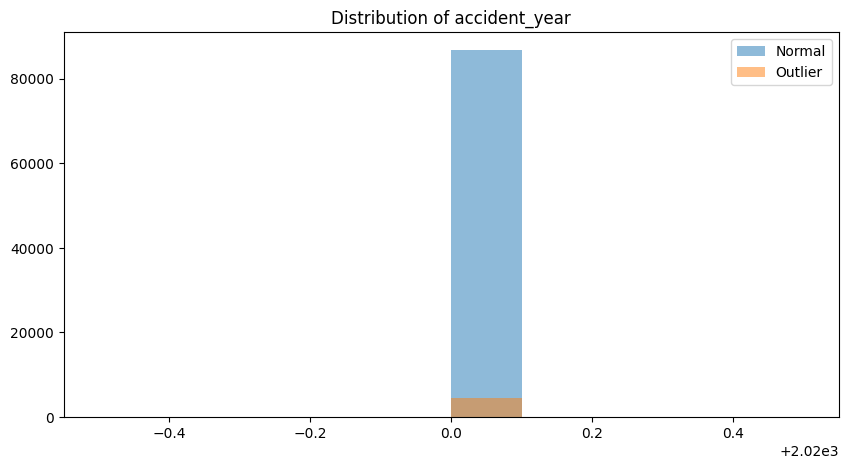

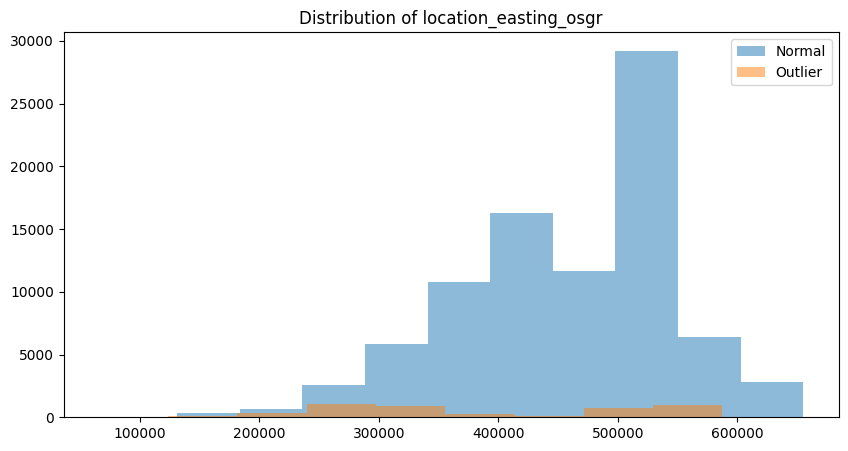

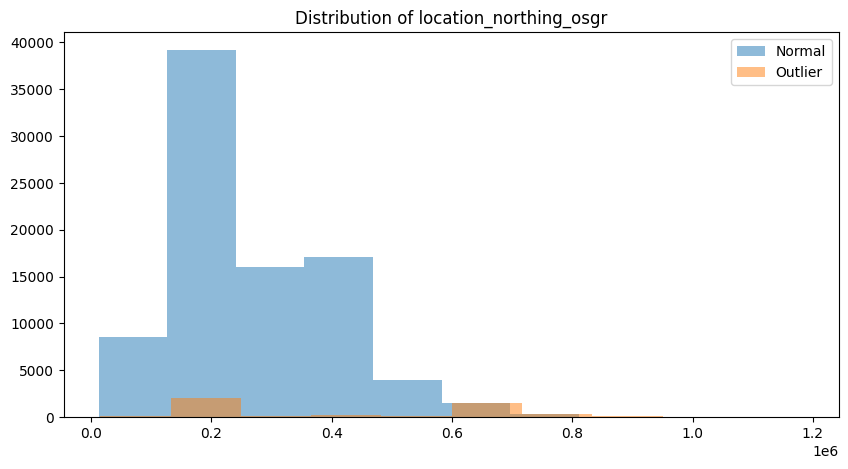

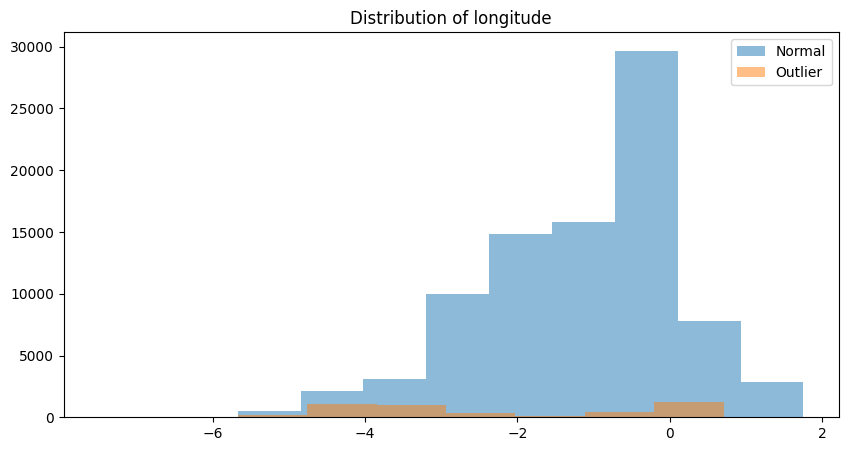

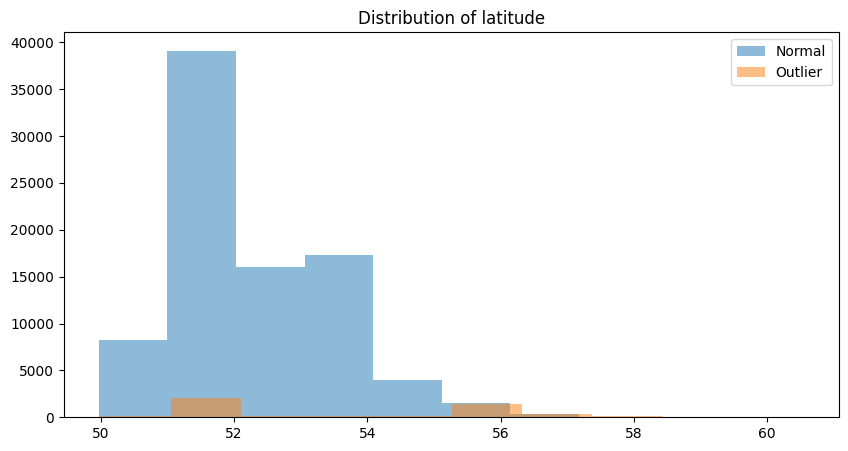

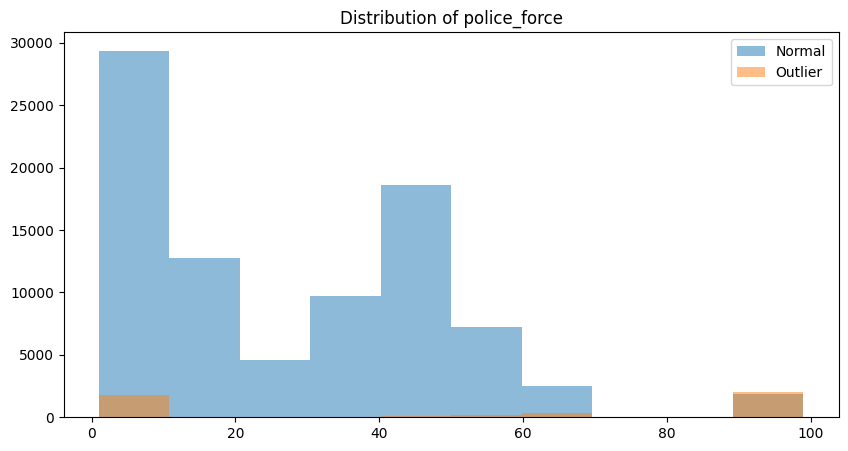

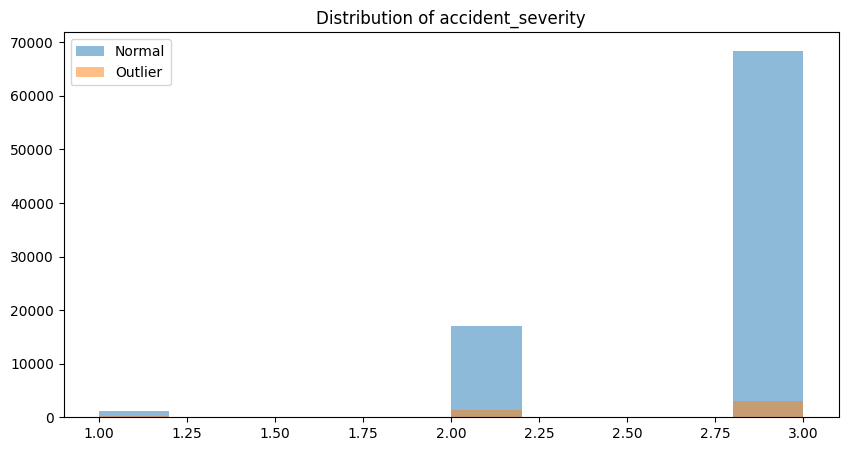

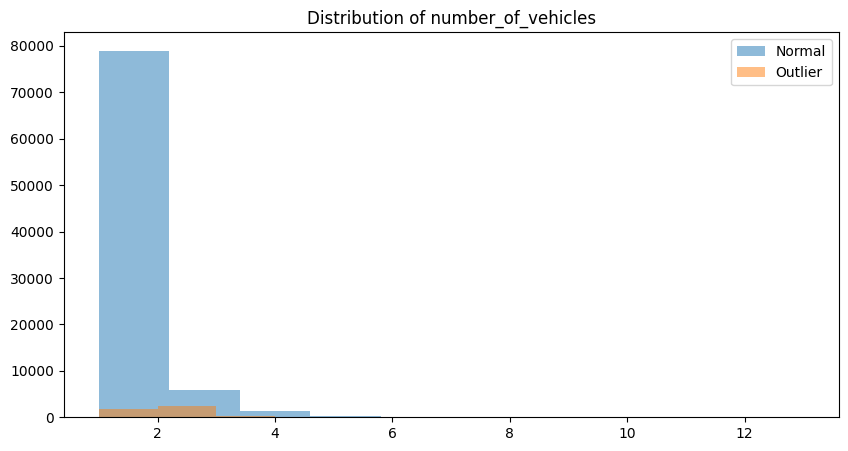

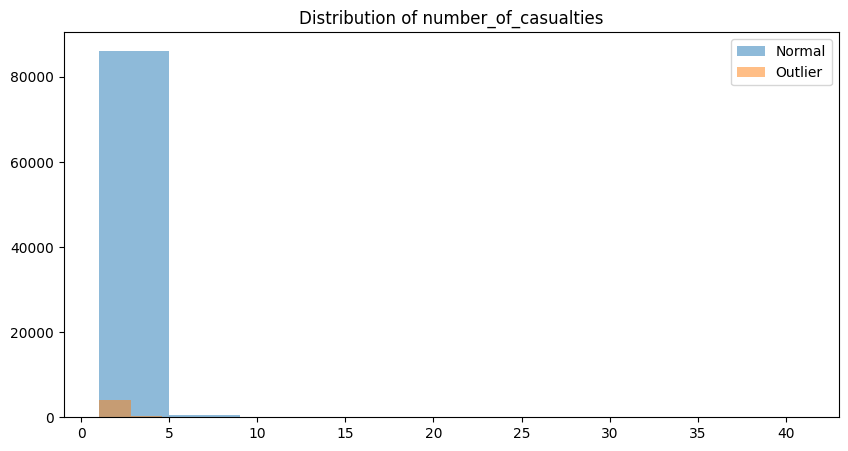

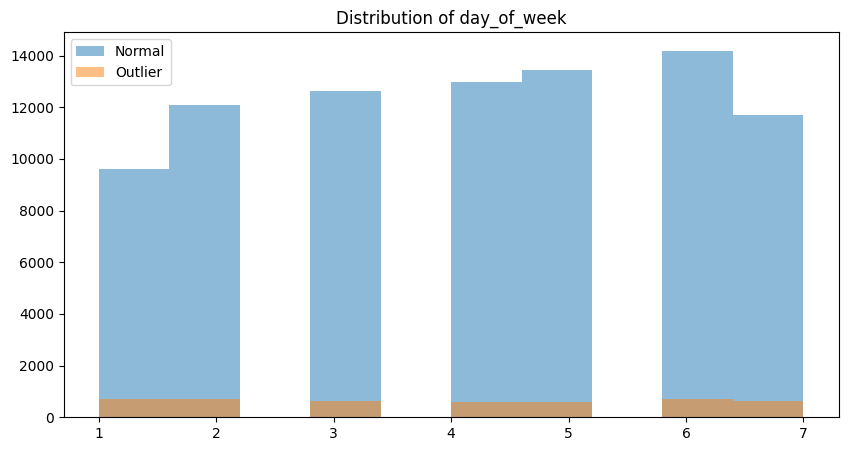

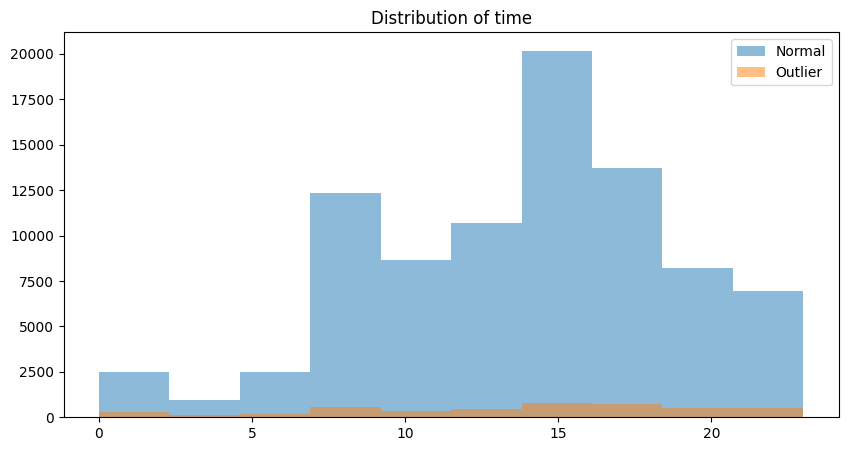

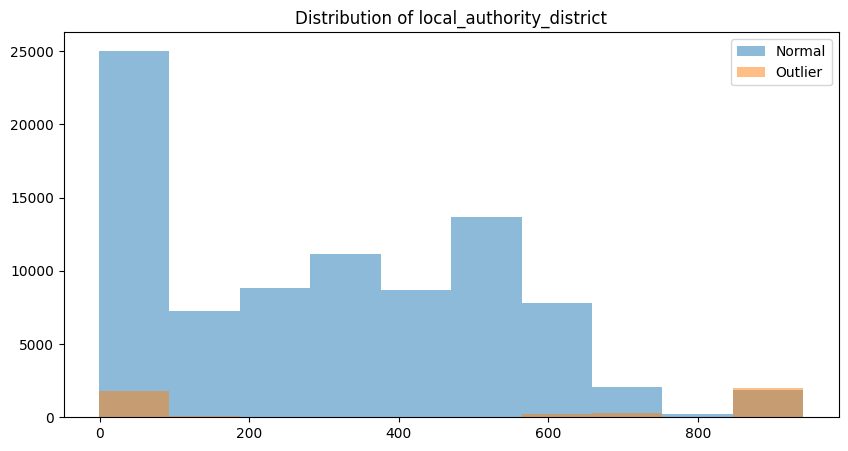

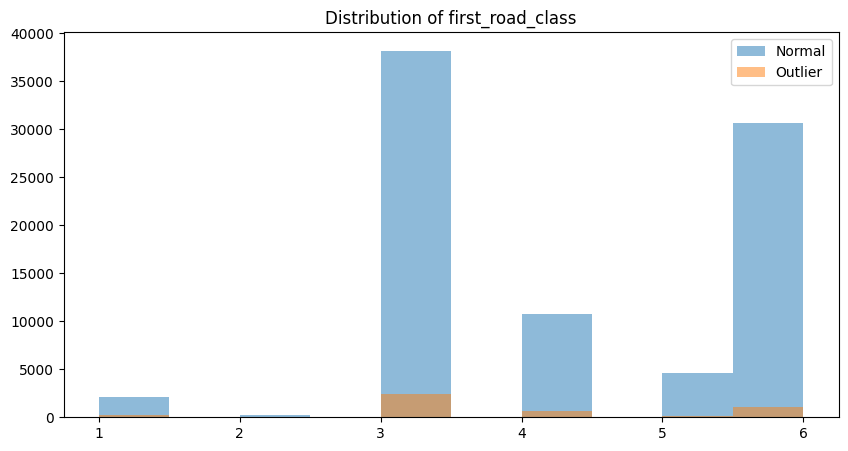

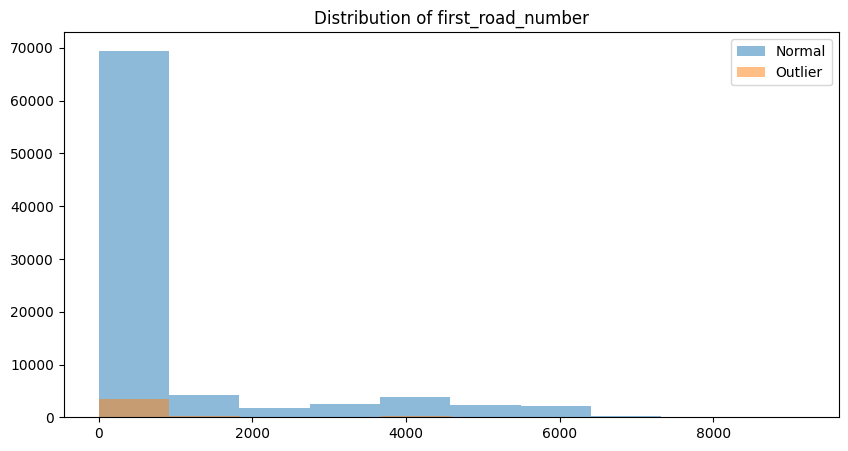

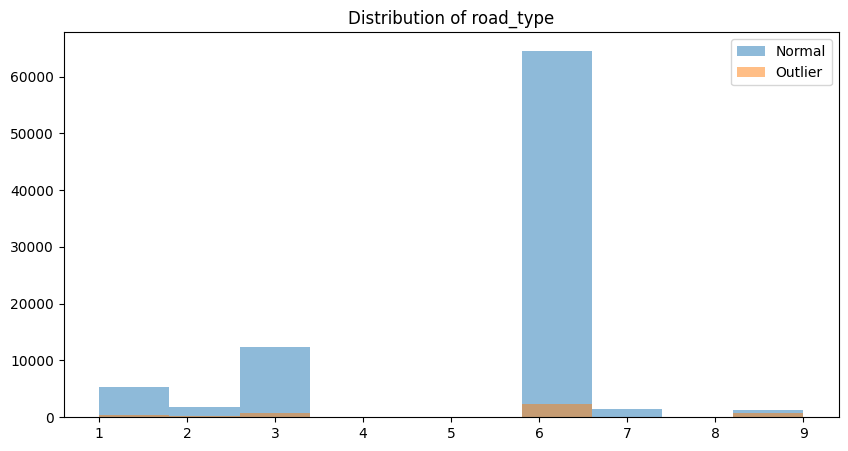

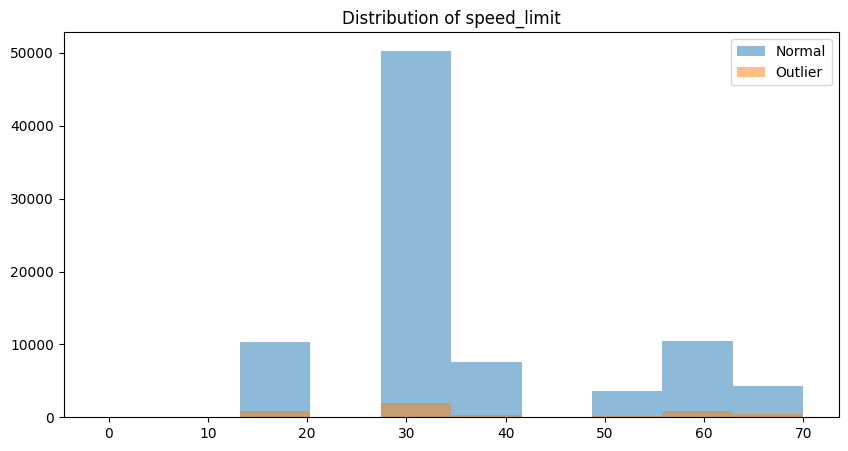

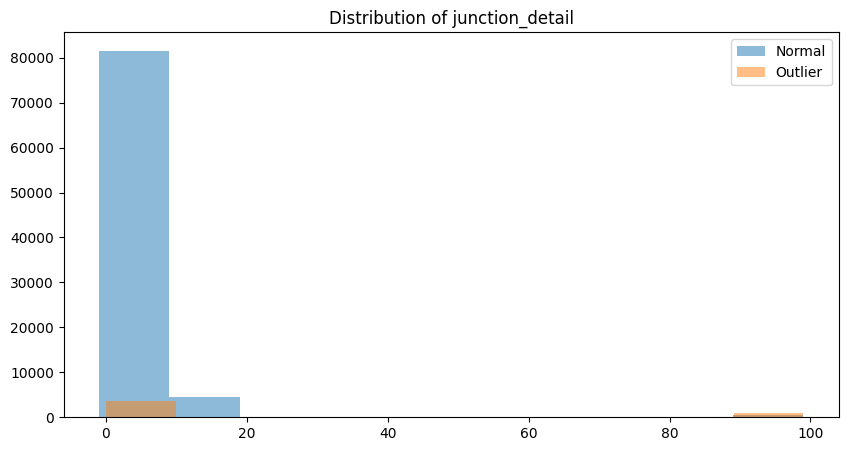

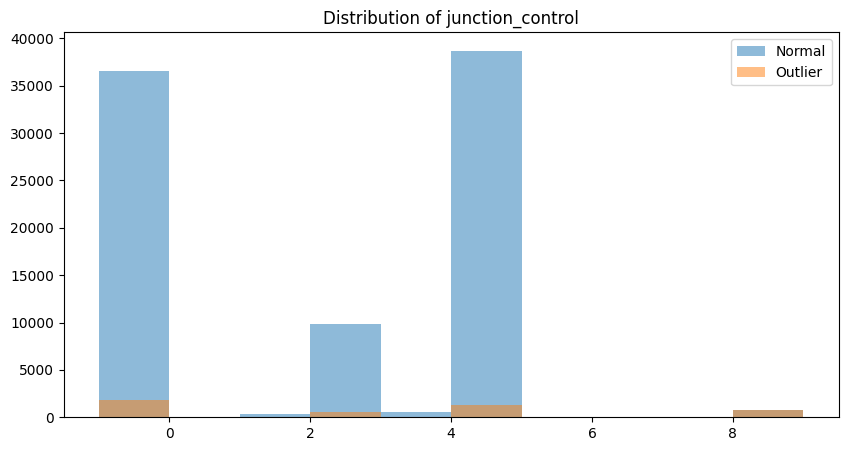

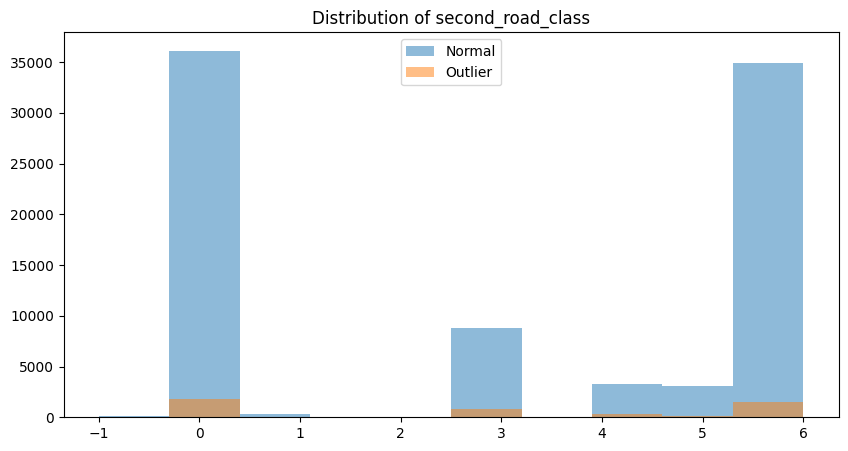

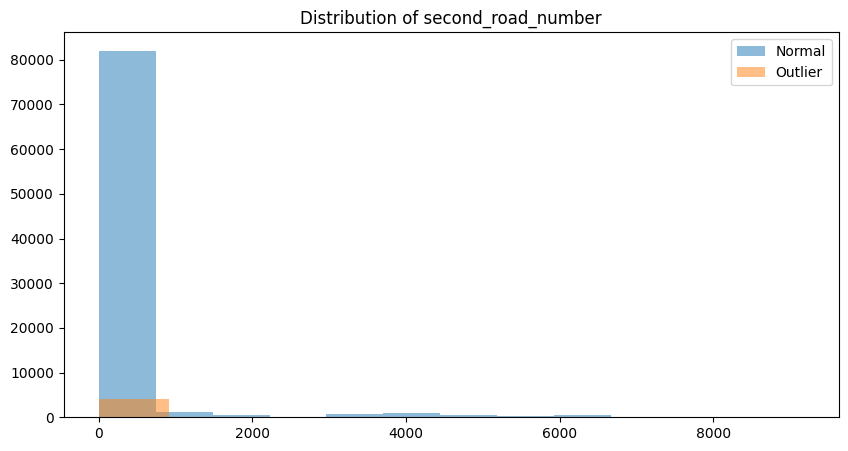

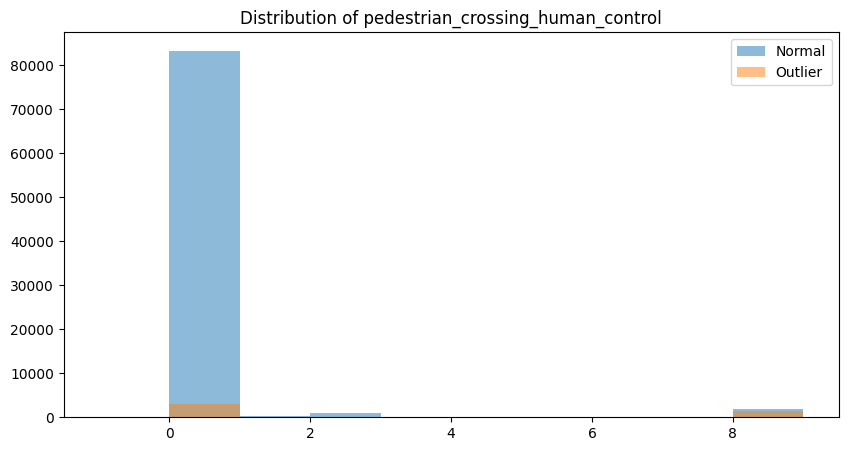

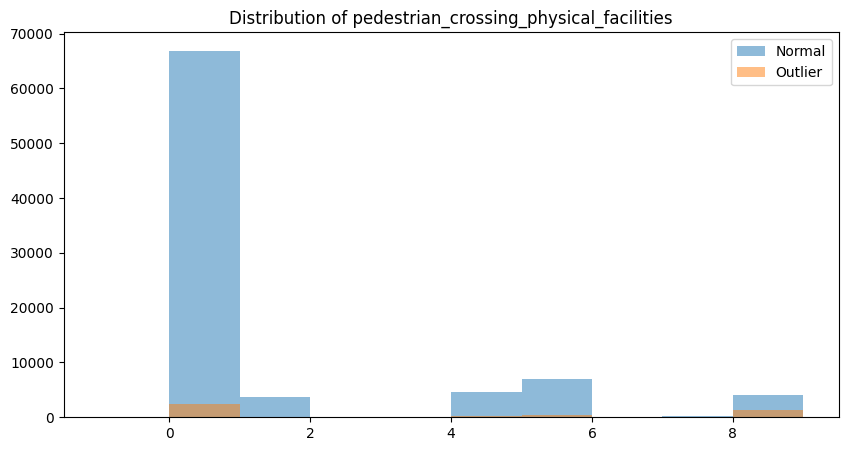

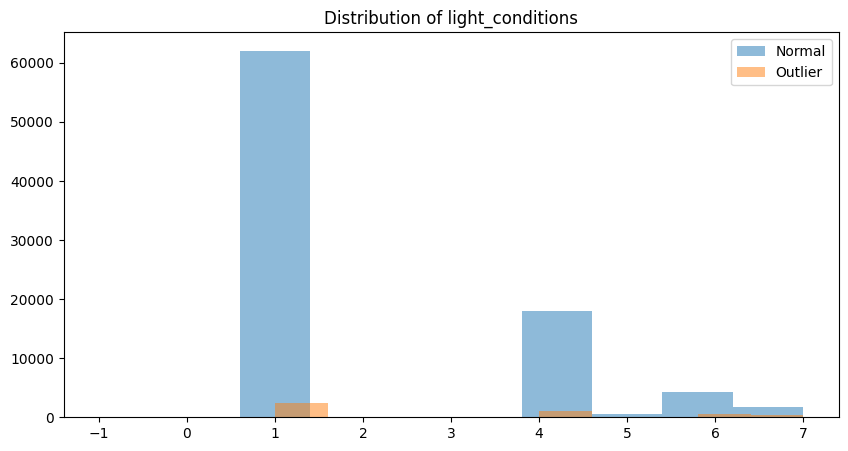

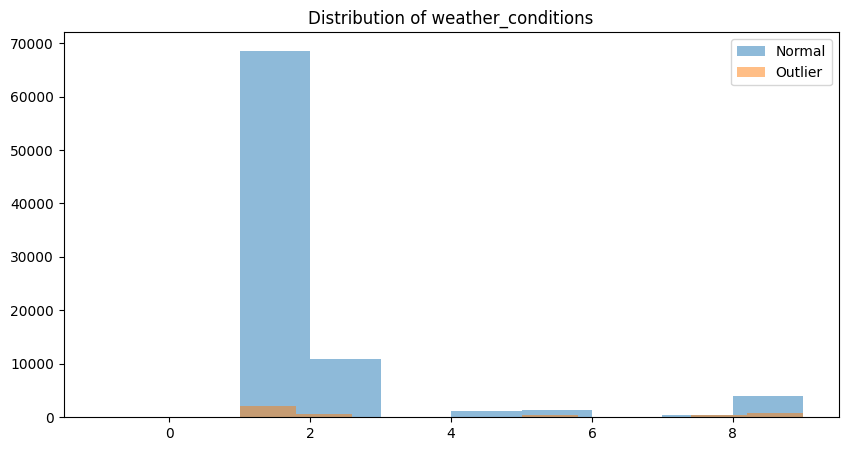

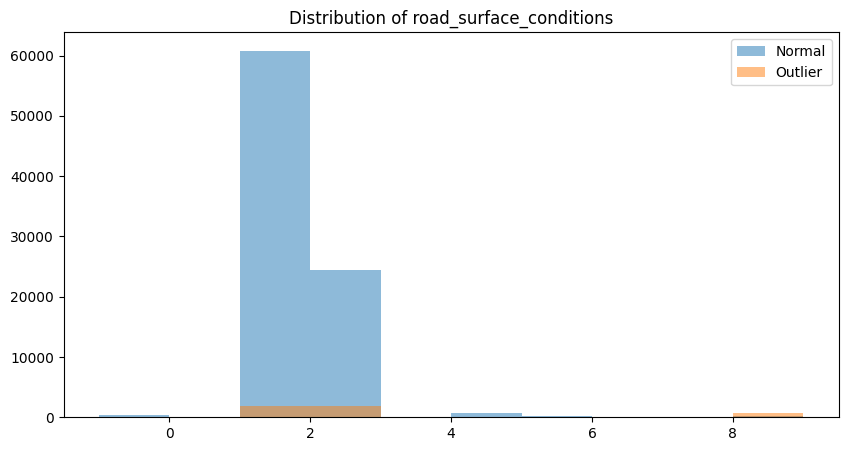

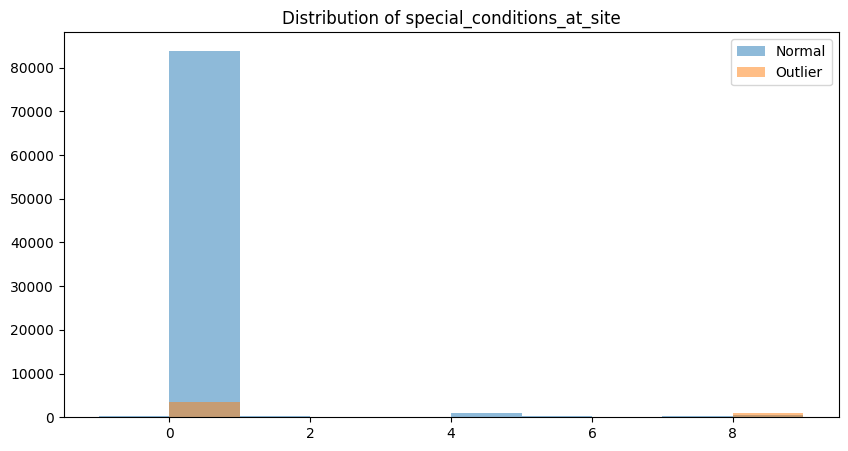

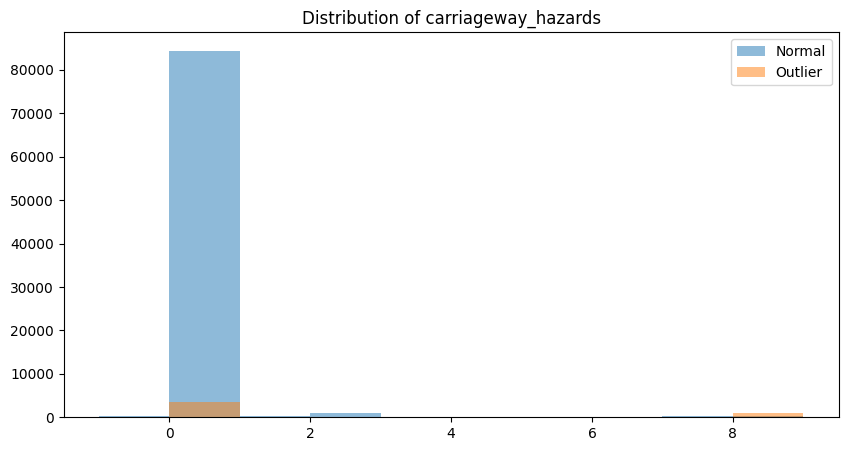

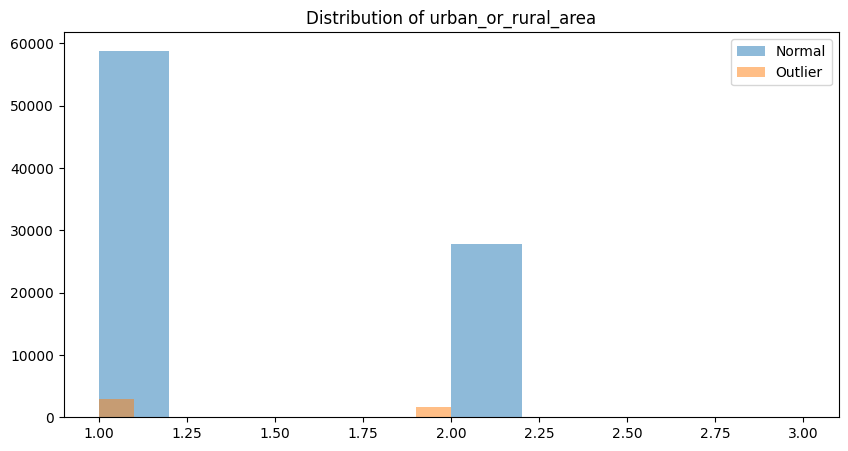

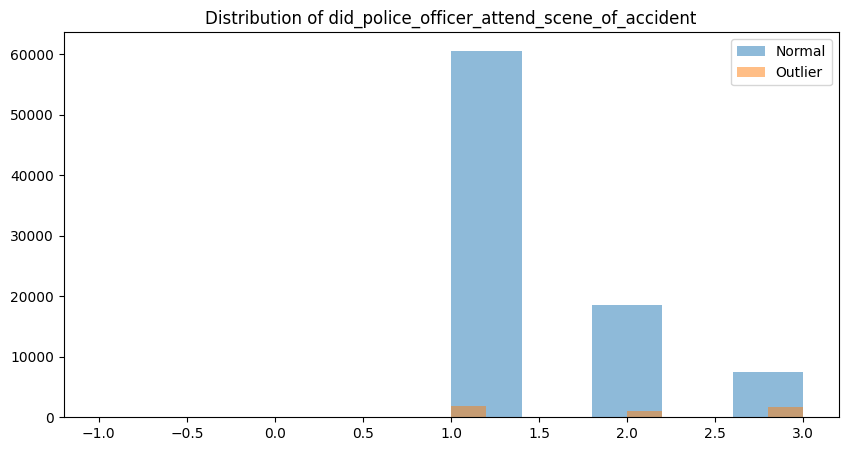

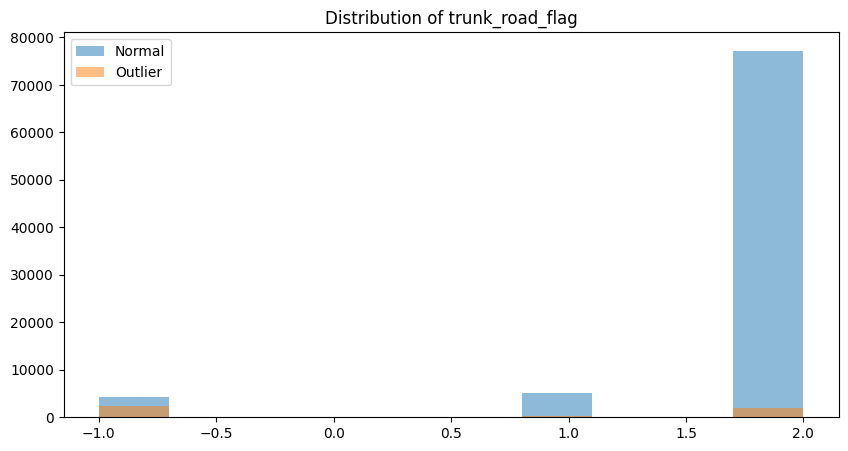

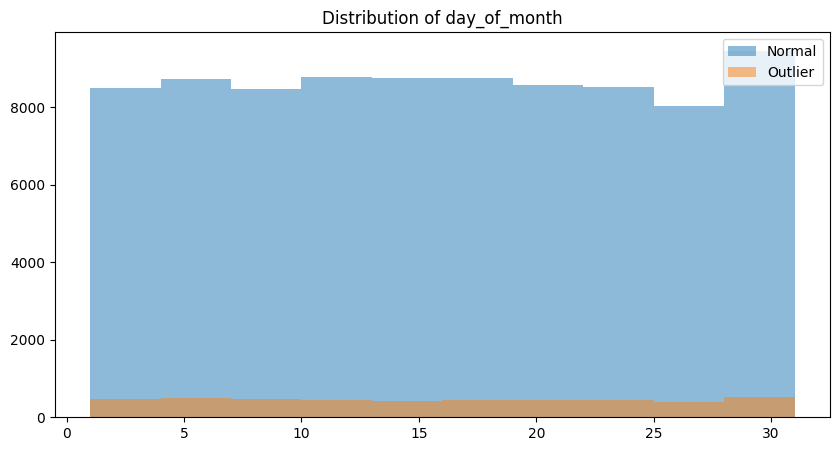

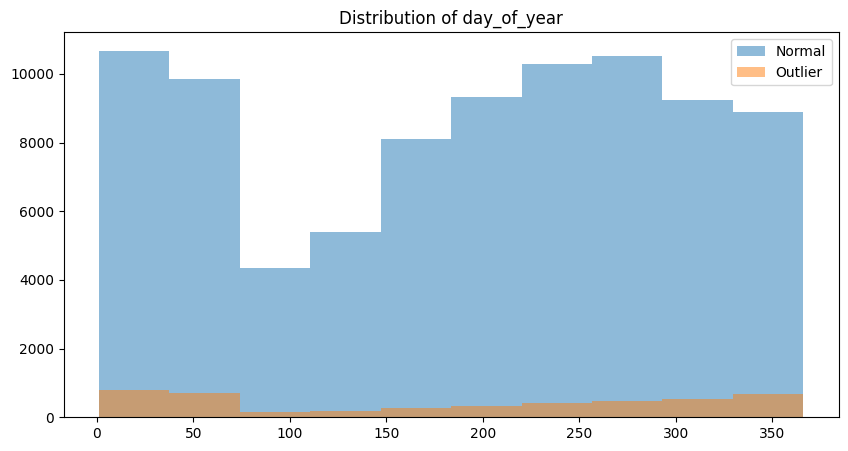

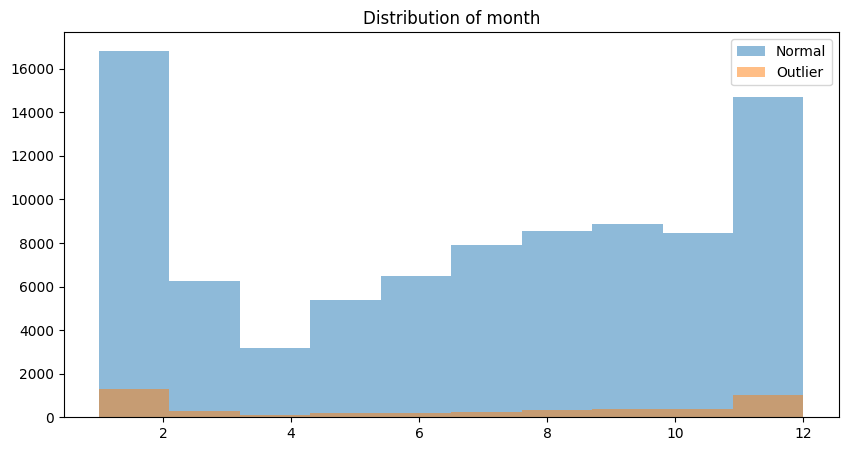

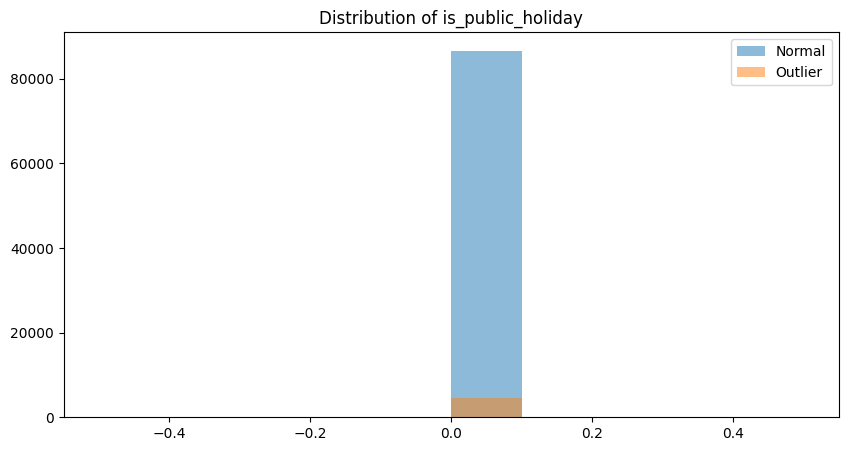

In [44]:
for col in num_cols:
    plt.figure(figsize=(10,5))
    plt.hist(data[data['outlier'] == 1][col], alpha=0.5, label='Normal')
    plt.hist(outliers[col], alpha=0.5, label='Outlier')
    plt.legend()
    plt.title(f'Distribution of {col}')
    plt.show()

In [25]:
accident[categ_cols]=accident[categ_cols].astype('category')
accident['lsoa_of_accident_location']=accident['lsoa_of_accident_location'].astype('category')

In [26]:
X=accident.drop(['accident_severity','accident_index', 'accident_year','accident_reference','date','datetime'],axis=1)
y=accident['accident_severity']

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
categorical_features_indices =np.where(X.dtypes == 'category')[0]
categorical_features_indices

array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])

In [29]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, recall_score, precision_score


<Axes: xlabel='accident_severity', ylabel='count'>

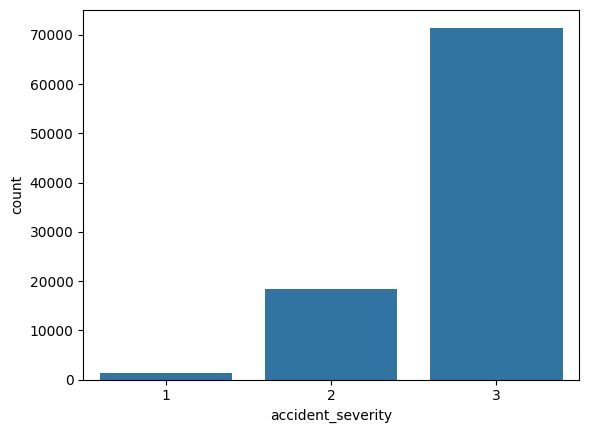

In [30]:
sns.countplot(x='accident_severity', data=accident)

In [31]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights_dict = dict(zip(classes, class_weights))

In [32]:
class_weights_dict

{1: 21.85454109753175, 2: 1.6562063016435122, 3: 0.42544982949164717}

In [33]:
list(class_weights_dict.values())/list(class_weights_dict.values())[0]

array([1.        , 0.07578317, 0.01946734])

In [34]:
# Catboost
#task_type='GPU', devices='0', 
cat = CatBoostClassifier(verbose=False, iterations =100, eval_metric = 'TotalF1',class_weights=class_weights_dict)
train_pool = Pool(X_train, y_train, cat_features = categorical_features_indices)
test_pool = Pool(X_valid, y_valid, cat_features = categorical_features_indices)
cat.fit(train_pool, eval_set= test_pool)
cat_pred = cat.predict(X_valid)
cat_recall = recall_score(y_valid,cat_pred,average='weighted')
cat_accuracy= accuracy_score(y_valid,cat_pred)
cat_precision = precision_score(y_valid,cat_pred,average='weighted')
cat_f1 = f1_score(y_valid,cat_pred,average='weighted')

print("CatBoost Recall score on validation set is : ",cat_recall)
print("CatBoost Accuracy score on validation set is : ",cat_accuracy)
print("CatBoost Precision score on validation set is : ",cat_precision)
print("CatBoost F1 Score score on validation set is : ",cat_f1)
print('--------'*15)

CatBoost Recall score on validation set is :  0.5243421052631579
CatBoost Accuracy score on validation set is :  0.5243421052631579
CatBoost Precision score on validation set is :  0.7419764515924215
CatBoost F1 Score score on validation set is :  0.5977990809224389
------------------------------------------------------------------------------------------------------------------------


In [35]:
print(classification_report(y_valid, cat_pred))

              precision    recall  f1-score   support

           1       0.05      0.64      0.09       292
           2       0.27      0.40      0.32      3657
           3       0.88      0.55      0.68     14291

    accuracy                           0.52     18240
   macro avg       0.40      0.53      0.36     18240
weighted avg       0.74      0.52      0.60     18240



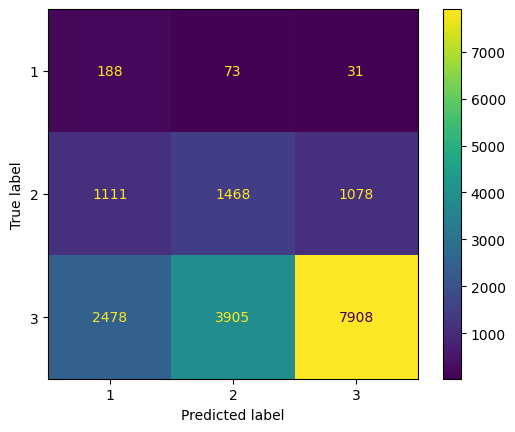

In [36]:
cm = confusion_matrix(y_valid, cat_pred, labels=cat.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=cat.classes_)
disp.plot()

plt.show()

In [37]:
y_valid.value_counts()

accident_severity
3    14291
2     3657
1      292
Name: count, dtype: int64

In [38]:
# LGBM
#device='gpu', 
lgb = LGBMClassifier(verbose=0, num_iterations=100, metric = 'MultiClass', class_weight=class_weights_dict, force_col_wise=True)
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_valid)
lgb_recall = recall_score(y_valid,lgb_pred,average='weighted')
lgb_accuracy= balanced_accuracy_score(y_valid,lgb_pred)
lgb_precision = precision_score(y_valid,lgb_pred,average='weighted')
lgb_f1 = f1_score(y_valid,lgb_pred,average='weighted')

print("LGBM Recall score on validation set is : ",lgb_recall)
print("LGBM Accuracy score on validation set is : ",lgb_accuracy)
print("LGBM Precision score on validation set is : ",lgb_precision)
print("LGBM F1 Score score on validation set is : ",lgb_f1)

print('--------'*15)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
LGBM Recall score on validation set is :  0.6570175438596492
LGBM Accuracy score on validation set is :  0.4004145970601414
LGBM Precision score on validation set is :  0.7127279883151946
LGBM F1 Score score on validation set is :  0.6781098838644741
------------------------------------------------------------------------------------------------------------------------


In [39]:
print(classification_report(y_valid, lgb_pred))

              precision    recall  f1-score   support

           1       0.04      0.02      0.03       292
           2       0.29      0.46      0.36      3657
           3       0.83      0.72      0.77     14291

    accuracy                           0.66     18240
   macro avg       0.39      0.40      0.39     18240
weighted avg       0.71      0.66      0.68     18240



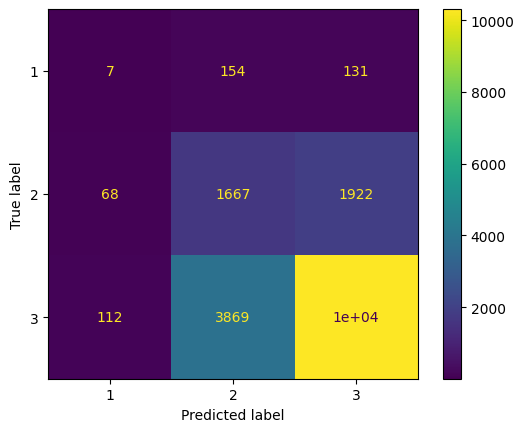

In [40]:
cm = confusion_matrix(y_valid, lgb_pred, labels=cat.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lgb.classes_)
disp.plot()

plt.show()